# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Matthew Clark
- Email: matthewclark965@gmail.com
- Id Dicoding: M891D5Y1083

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib   
import warnings
warnings.filterwarnings('ignore')
print("Semua library berhasil di import")

Semua library berhasil di import


## Menyiapkan data yang akan digunakan

### Data Understanding

In [2]:
# Load Dataset
df = pd.read_csv("employee_data.csv")
# Menampilkan 5 baris pertama
print("Contoh Data ")
display(df.head())


# Cek tipe data, missing values, dan duplikasi
# Cek tipe data
print("\nInfo Dataset")
df.info()
# Cek missing values
print("\nCek Data Kosong")
print(f"Jumlah Missing Values: {df.isnull().sum().sum()}")

# Cek Duplikat
print("\nCek Data Duplikat")
print(f"Jumlah Duplikat: {df.duplicated().sum()}")

# Cek Target
print("\nDistribusi Target 'Attrition'")
print(df['Attrition'].value_counts())

Contoh Data 


,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2



Info Dataset
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   str    
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   str    
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   str    
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   str    
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLe

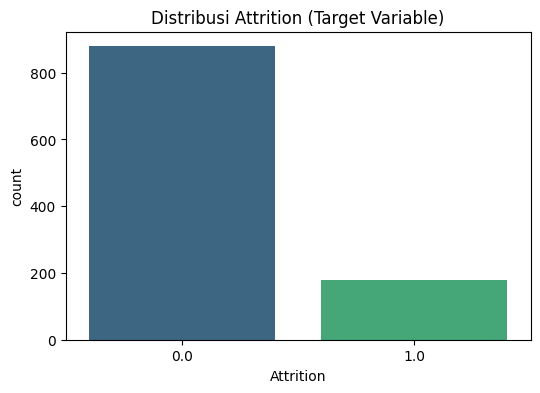

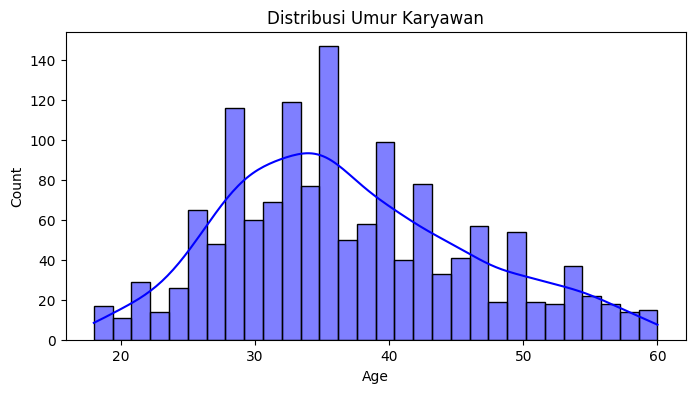

In [3]:
# Univariate Analysis
# Melihat Distribusi Target (Attrition)
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df, palette='viridis')
plt.title('Distribusi Attrition (Target Variable)')
plt.show()

# Melihat Distribusi Umur Karyawan
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True, color='blue')
plt.title('Distribusi Umur Karyawan')
plt.show()

# Terlihat bahwa data tidak seimbang, jumlah karyawan yang Stay jauh lebih banyak daripada yang Resign.

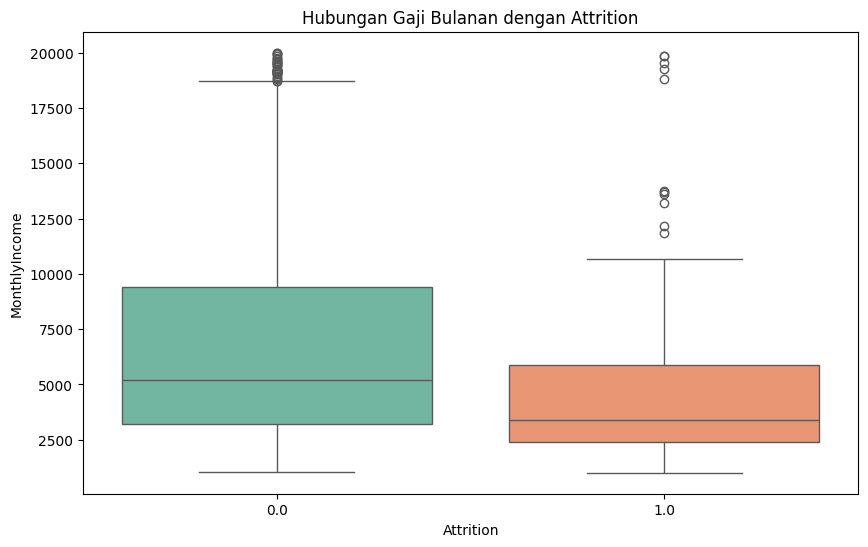

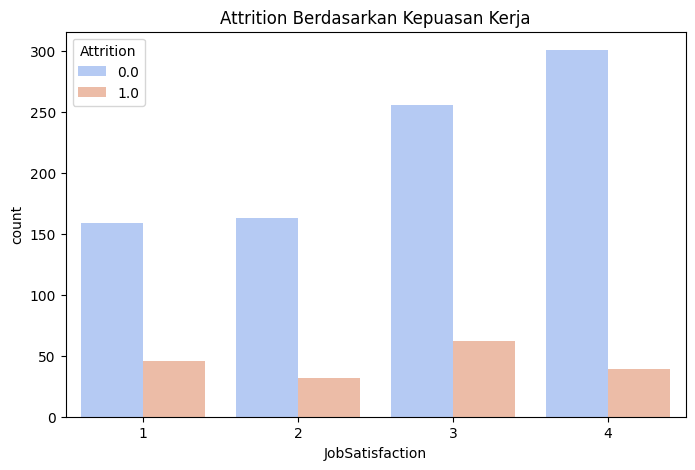

In [4]:
# Bivariate Analysis
# Attrition vs Monthly Income
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df, palette='Set2')
plt.title('Hubungan Gaji Bulanan dengan Attrition')
plt.show()
# Rata-rata gaji karyawan yang Resign cenderung lebih rendah dibandingkan yang bertahan.


# Attrition vs Job Satisfaction
plt.figure(figsize=(8, 5))
sns.countplot(x='JobSatisfaction', hue='Attrition', data=df, palette='coolwarm')
plt.title('Attrition Berdasarkan Kepuasan Kerja')
plt.show()
# Karyawan dengan tingkat kepuasan rendah (1) memiliki rasio resign yang lebih tinggi.

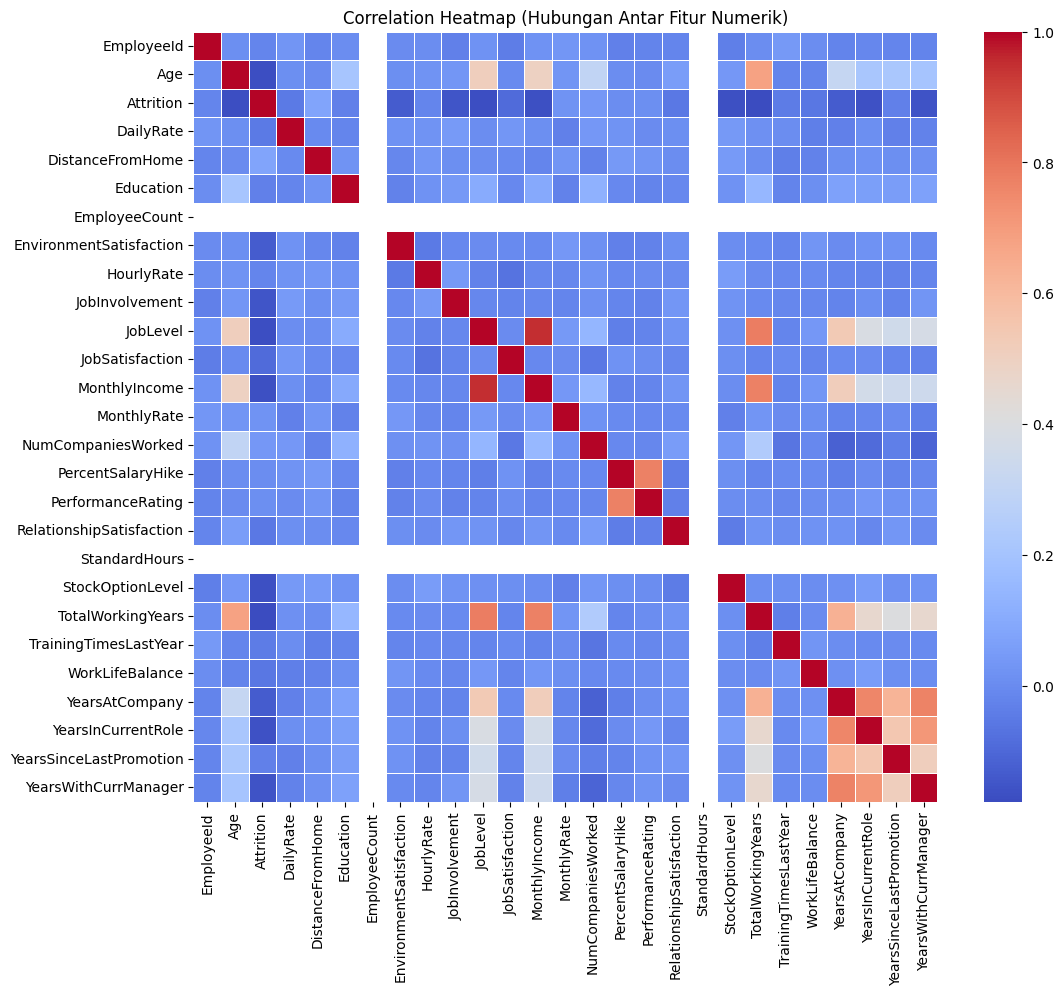

In [5]:
# Multivariate Analysis - Heatmap Korelasi
plt.figure(figsize=(12, 10))

# Hanya ambil kolom angka untuk korelasi
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

# Hitung korelasi
correlation = numerical_cols.corr()

# Buat Heatmap
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Hubungan Antar Fitur Numerik)')
plt.show()

### Data Preparation / Preprocessing

In [6]:
# Data Cleaning & Preprocessing
# Handling Missing Values
df_clean = df.dropna(subset=['Attrition']).copy()

# Membuang Kolom yang Tidak Dipakai (Berdasarkan analisis Heatmap)
# - EmployeeCount, Over18, StandardHours: Isinya sama semua (tidak punya pola)
# - EmployeeId: Hanya nomor urut, tidak ada pengaruh ke target
useless_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeId']
# Hapus kolom yang ada di data
cols_to_drop = [col for col in useless_cols if col in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)

# Encoding (Mengubah Huruf menjadi Angka)
le = LabelEncoder()
# Cari kolom yang isinya Teks (Object)
object_cols = df_clean.select_dtypes(include=['object', 'string']).columns
print("Melakukan Encoding pada kolom:")
for col in object_cols:
    df_clean[col] = le.fit_transform(df_clean[col])
    print(f"- {col}")

# Pastikan kolom Attrition tipe datanya Integer (0/1)
df_clean['Attrition'] = df_clean['Attrition'].astype(int)

print(f"\nUkuran Data Setelah Cleaning: {df_clean.shape}")
print("Contoh Data Hasil Encoding:")
display(df_clean.head(3))

Melakukan Encoding pada kolom:
- BusinessTravel
- Department
- EducationField
- Gender
- JobRole
- MaritalStatus
- OverTime

Ukuran Data Setelah Cleaning: (1058, 31)
Contoh Data Hasil Encoding:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,37,1,2,1141,1,11,2,3,1,0,...,3,1,0,15,2,1,1,0,0,0
2,51,1,2,1323,1,4,4,1,1,1,...,3,3,3,18,2,4,10,0,2,7
3,42,0,1,555,2,26,3,2,3,0,...,3,4,1,23,2,4,20,4,4,8


In [7]:
# Data Splitting & SMOTE
# Pisahkan Fitur (X) dan Target (y)
X = df_clean.drop(columns=['Attrition']) # Semua kolom kecuali Attrition
y = df_clean['Attrition']                # Hanya kolom Attrition

# Split Data (80% Training, 20% Testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sebelum SMOTE ")
print(f"Jumlah Training Set: {X_train.shape[0]}")
print(f"Jumlah yang Resign (1): {sum(y_train==1)}")
print(f"Jumlah yang Stay (0): {sum(y_train==0)}")

# SMOTE pada data training
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSetelah SMOTE")
print(f"Jumlah Training Set Baru: {X_train_resampled.shape[0]}")
print(f"Jumlah yang Resign (1): {sum(y_train_resampled==1)}")
print(f"Jumlah yang Stay (0): {sum(y_train_resampled==0)}")
print("\nSukses! Sekarang jumlah Yes dan No sudah seimbang (50:50).")

Sebelum SMOTE 
Jumlah Training Set: 846
Jumlah yang Resign (1): 140
Jumlah yang Stay (0): 706

Setelah SMOTE
Jumlah Training Set Baru: 1412
Jumlah yang Resign (1): 706
Jumlah yang Stay (0): 706

Sukses! Sekarang jumlah Yes dan No sudah seimbang (50:50).


## Modeling

In [8]:
# Model Training & Prediction (Random Forest Classifier)
# Inisialisasi Model
# n_estimators=100 (100 pohon keputusan) 
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih Model (Training)
# Melatih dengan data yang sudah di SMOTE (X_train_resampled, y_train_resampled)
print("Sedang melatih model")
model.fit(X_train_resampled, y_train_resampled)
print("Pelatihan selesai!")

# Lakukan Prediksi pada Data Testing
# Menguji dengan data asli yang belum disentuh (X_test)
y_pred = model.predict(X_test)

print("\nModel sudah berhasil memprediksi data uji.")

Sedang melatih model
Pelatihan selesai!

Model sudah berhasil memprediksi data uji.


## Evaluation

Akurasi Model: 83.49%

Laporan Klasifikasi
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       173
           1       0.59      0.33      0.43        39

    accuracy                           0.83       212
   macro avg       0.73      0.64      0.66       212
weighted avg       0.81      0.83      0.82       212



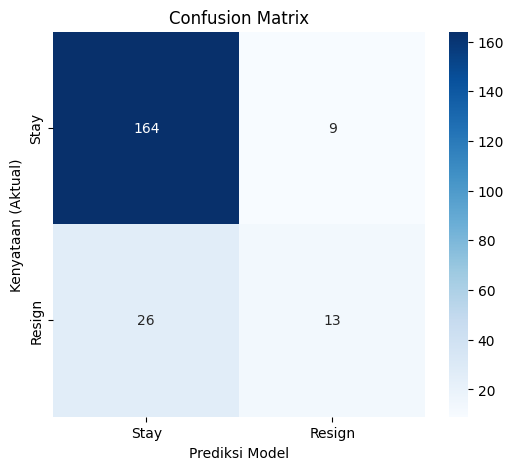

In [9]:
# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hitung Akurasi 
# Berapa persen jawaban yang benar?
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

# Menampilkan Laporan 
print("\nLaporan Klasifikasi")
print(classification_report(y_test, y_pred))

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Resign'], yticklabels=['Stay', 'Resign'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix')
plt.show()

Top 10 Faktor Penyebab Resign


,Feature,Importance
22,StockOptionLevel,0.073037
13,JobSatisfaction,0.065153
7,EnvironmentSatisfaction,0.056698
29,YearsWithCurrManager,0.053587
15,MonthlyIncome,0.050930
16,MonthlyRate,0.047156
23,TotalWorkingYears,0.045768
1,BusinessTravel,0.044930
9,HourlyRate,0.044229
10,JobInvolvement,0.043445


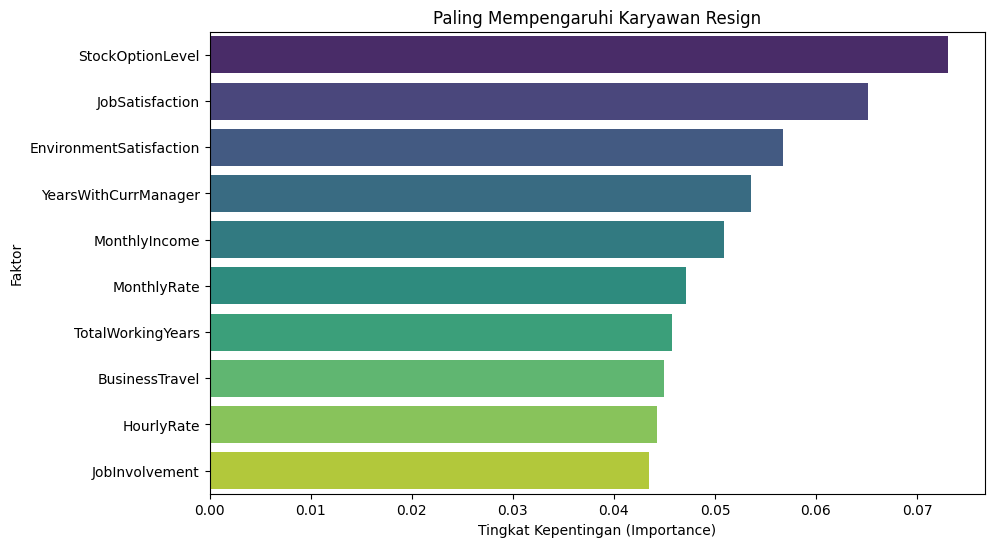

In [10]:
# Menampilkan Fitur Penting (Feature Importance)
# Ambil data yang dianggap penting oleh model
importances = model.feature_importances_

# Membuat DataFrame agar outputnya rapi
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Urutkan dari yang paling berpengaruh ke yang tidak berpengaruh
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Menampilkan 10 Faktor Teratas
print("Top 10 Faktor Penyebab Resign")
display(feature_importance_df.head(10))

# Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Paling Mempengaruhi Karyawan Resign')
plt.xlabel('Tingkat Kepentingan (Importance)')
plt.ylabel('Faktor')
plt.show()

### Kesimpulan

- Performa Model: Model mencapai akurasi sebesar 83.49%. Artinya, secara umum model sudah cukup baik membedakan antara karyawan yang bertahan dan yang akan keluar. Namun kemampuan mendeteksi yang resign masih terbatas karena hanya mendapatkan Recall 33%.
- Berdasarkan analisis Feature Importance yang dihasilkan oleh model Machine Learning, terlihat bahwa keputusan karyawan untuk melakukan resign tidak didorong oleh 1 faktor saja, melainkan kombinasi berbagai faktor. Dimana yang paling signifikan menunjukkan bahwa StockOptionLevel (Tingkat Kepemilikan Saham) merupakan indikator utama dengan bobot pengaruh tertinggi. Hal ini mengindikasikan bahwa karyawan yang tidak memiliki insentif jangka panjang atau rasa kepemilikan terhadap perusahaan cenderung lebih mudah untuk keluar. Faktor krusial berikutnya diikuti oleh aspek psikologis dan lingkungan, yaitu JobSatisfaction dan EnvironmentSatisfaction, yang dampaknya terbukti lebih besar dibandingkan besaran gaji bulanan (MonthlyIncome).

#### Rekomendasi Action Items

1. **Evaluasi Benefit Saham**: Berikan opsi saham tidak hanya untuk eksekutif, tapi juga karyawan level menengah berprestasi untuk meningkatkan rasa memiliki.

2. **Perbaiki Lingkungan Kerja**: Lakukan survei rutin khusus fasilitas dan kenyamanan kerja. Tindak lanjuti keluhan teknis.

3. **Pelatihan Manajer**: Latih manajer untuk lebih suportif. Hubungan buruk atau stagnan dengan atasan adalah pemicu resign terbesar ke-4

## Tableau

In [11]:
# Data Untuk Dashboard Tableau
# Kita ambil ulang data aslinya agar menjadi teks bukan angka
df_dashboard = pd.read_csv('employee_data.csv') 

# Kita lakukan pembersihan standar (Tanpa Encoding)
# Hapus baris kosong di target
df_dashboard = df_dashboard.dropna(subset=['Attrition'])

# Hapus kolom sampah yang tidak berguna
useless_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeId']
df_dashboard = df_dashboard.drop(columns=[col for col in useless_cols if col in df_dashboard.columns])

# Simpan ke CSV
df_dashboard.to_csv('dashboard_data.csv', index=False)

print("File 'dashboard_data.csv' berhasil dibuat.")

File 'dashboard_data.csv' berhasil dibuat.


In [12]:
# Menyimpan Data Feature Importance ke CSV
# Mengambil Top 10 Faktor 
top_10_factors = feature_importance_df.head(10)

# Simpan ke CSV baru
top_10_factors.to_csv('faktor_utama_resign.csv', index=False)

print("File 'faktor_utama_resign.csv' berhasil dibuat.")

File 'faktor_utama_resign.csv' berhasil dibuat.


In [13]:
# Menyimpan Model dengan joblib
joblib.dump(model, 'model.joblib')

print("Berhasil")

Berhasil
